In [1]:
!pip install tensorflow-ranking==0.5.0
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 75.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstall

**Importing  libraries**

**Importing  libraries**

In [2]:
import tensorflow_ranking as tfr
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten
from sklearn.model_selection import train_test_split
from collections import defaultdict



from sklearn.metrics import classification_report

print("TensorFlow version:", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.9.1


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

### Custom Hamming Loss Metric

In this code  a custom Hamming Loss metric is defined using TensorFlow and Keras. The Hamming Loss is a metric used to evaluate the accuracy of multi-label classification models. Here's an explanation of the code:

#### Custom Metric Class

- A custom metric class named `HammingLoss` is defined. This class extends the `Metric` class provided by TensorFlow/Keras.

- The `__init__` method initializes the metric. It accepts parameters such as `threshold` and `name`. The threshold defines the threshold value for binary conversion of predictions. The `hamming_loss` and `count` variables are created as TensorFlow variables to keep track of the Hamming loss and the number of samples.

#### `update_state` Method

- The `update_state` method is used to update the state of the metric. It accepts `y_true` (true labels), `y_pred` (predicted probabilities), and `sample_weight` (optional).

- The method first converts the predicted probabilities to binary labels based on the specified threshold.

- It then computes the absolute differences between the true labels and the binary predictions for each sample and class.

- The mean over classes for each sample is calculated, which represents the Hamming loss for that sample.

- The Hamming loss and the sample count are updated accordingly.

#### `result` Method

- The `result` method calculates the final Hamming loss by dividing the accumulated Hamming loss by the sample count.

#### `reset_state` Method

- The `reset_state` method is used to reset the Hamming loss and sample count at the end of each epoch. This is important to ensure that the metric calculations are isolated for each epoch.

This custom Hamming Loss metric can be used during the training of multi-label classification models to monitor and evaluate the model's performance with regard to label prediction accuracy.




In [3]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class HammingLoss(Metric):
    def __init__(self, threshold=0.5, name="hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = tf.Variable(threshold, trainable=False, dtype=tf.float32)
        self.hamming_loss = self.add_weight(name="hl", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tmp = tf.math.abs(y_true - y_pred_binary)
        hl = tf.math.reduce_mean(tmp, axis=-1)
        self.hamming_loss.assign_add(tf.math.reduce_sum(hl))
        self.count.assign_add(tf.cast(tf.size(y_true) / tf.shape(y_true)[-1], tf.float32))
    def result(self):
        return self.hamming_loss / self.count
    def reset_state(self):
        self.hamming_loss.assign(0.)
        self.count.assign(0.)

### Data Loading and Filtering

This section covers the process of loading data from CSV files and applying filtering to include only specific rows based on the value of the `Disease_Risk` column.

- The data is loaded from the following CSV files:
  - Training data: `train_file.csv`
  - Validation data: `val_file.csv`
  - Test data: `test_file.csv`

- To ensure that the analysis focuses on samples relevant to disease risk, a filter is applied to select rows where the `Disease_Risk` column is equal to 1. This step helps exclude unrelated data.

- Additionally, the disease labels are extracted into the `labels` variable for further reference.

- Finally, information is provided on the sizes of the resulting datasets, including the number of samples in the training, validation, and test sets.

This data preparation process ensures that subsequent analysis or model training is based on the most relevant samples with disease risk.


In [4]:
import pandas as pd
train_data = pd.read_csv('/kaggle/input/my-data/train_file.csv')
val_data = pd.read_csv('/kaggle/input/my-data/val_file.csv')
test_data = pd.read_csv('/kaggle/input/my-data/test_file.csv')
train_data = train_data[train_data['Disease_Risk'] == 1]
val_data = val_data[val_data['Disease_Risk'] == 1]
test_data = test_data[test_data['Disease_Risk'] == 1]
labels = train_data.columns[2:-1]
len_train_data = len(train_data)
len_val_data = len(val_data)
len_test_data = len(test_data)
filtered_size = len_train_data + len_val_data + len_test_data

len(train_data), len(val_data), len(test_data),filtered_size

(7502, 934, 953)

### Custom Image Augmentation Layer

In the following code  a custom image augmentation layer is defined using TensorFlow and Keras. This custom layer is designed to apply various image augmentation operations for data preprocessing and augmentation in deep learning models. Here's an explanation of the code:

#### Custom Image Augmentation Class

- The code defines a class called `CustomImageAugmentation` that inherits from `tf.keras.layers.Layer`. This class serves as the foundation for applying image augmentation techniques to input images.

- The class constructor (`__init__`) is responsible for initializing the image augmentation layer. It accepts a set of parameters that allow customization of which augmentation operations are applied. These operations include horizontal flipping, rotation, brightness adjustment, contrast adjustment, saturation adjustment, hue adjustment, scaling, cropping, grid distortion, compression, Gaussian noise, Gaussian blur, downscaling, gamma correction, and elastic transformation.

- The `call` method within this class is used to apply the specified augmentation operations to input images. It includes a parameter named `apply` that controls whether the augmentations should be applied or not.

- The augmentation operations are diverse and encompass random horizontal flipping, random rotation, random brightness, contrast, saturation, and hue adjustments, scaling, and more. The application of each operation is controlled by the corresponding class attribute, such as `self.flip` and `self.rotate`.

- If the `apply` parameter is set to `True`, the augmentation operations are applied to the input images; otherwise, the original images are returned.

- The `img_aug` variable represents an instance of the `CustomImageAugmentation` class, which can be used for data augmentation within image-based deep learning models.

This custom image augmentation layer offers flexibility in specifying and applying image transformations, enhancing model generalization and performance when working with image datasets.


In [5]:
import tensorflow as tf
class CustomImageAugmentation(tf.keras.layers.Layer):
    def __init__(self, flip=True, rotate=True, brightness=True,
                 contrast=True, saturation=True, hue=True, scale=False,
                 crop=False, grid_distortion=False, compression=False,
                 gaussian_noise=False, gaussian_blur=False,
                 downscaling=False, gamma=False, elastic_transform=False, **kwargs):
        super(CustomImageAugmentation, self).__init__(**kwargs)
        self.flip = flip
        self.rotate = rotate
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.scale = scale
        self.crop = crop
        self.grid_distortion = grid_distortion
        self.compression = compression
        self.gaussian_noise = gaussian_noise
        self.gaussian_blur = gaussian_blur
        self.downscaling = downscaling
        self.gamma = gamma
        self.elastic_transform = elastic_transform

    def call(self, inputs, apply=True):
        if apply:
            augmented = tf.image.random_flip_left_right(inputs) if self.flip else inputs
            augmented = tf.image.rot90(augmented, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) if self.rotate else augmented
            augmented = tf.image.random_brightness(augmented, max_delta=0.2) if self.brightness else augmented
            augmented = tf.image.random_contrast(augmented, lower=0.5, upper=1.5) if self.contrast else augmented
            augmented = tf.image.random_saturation(augmented, lower=0.5, upper=1.5) if self.saturation else augmented
            augmented = tf.image.random_hue(augmented, max_delta=0.2) if self.hue else augmented
            return augmented
        else:
            return inputs
img_aug = CustomImageAugmentation()

### Custom Image Data Generator for Augmentation

In this code a custom image data generator is defined using TensorFlow and Keras. This data generator is designed to apply various image augmentation operations to preprocess and augment data in deep learning models. Here's an explanation of the code:

#### Custom Image Data Generator Class

- A custom image data generator class is created using TensorFlow and Keras.

- The data generator is configured with various augmentation operations that can be applied during data preprocessing.

- The `preprocessing_function` parameter is defined as a lambda function that utilizes the `img_aug` function with the `apply=True` flag to apply augmentation operations.

- The defined data generator can be used to preprocess and augment images during the training of deep learning models, enhancing the model's ability to learn from diverse and augmented data.




In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=lambda x: img_aug(x, apply=True)
)

### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (380, 380), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (380, 380) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [7]:
target_size=(380, 380)
batch_size=32
train_generatorb4 = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)
val_generatorb4 = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)
test_generatorb4 = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 7502 validated image filenames.
Found 934 validated image filenames.
Found 953 validated image filenames.


### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (224, 224), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (224, 224) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [8]:
target_size=(224, 224)

train_generatorv2 = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)
val_generatorv2 = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)
test_generatorv2 = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 7502 validated image filenames.
Found 934 validated image filenames.
Found 953 validated image filenames.


### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (300, 300), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (300, 300) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [9]:
target_size=(300, 300)

train_generatorb3 = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)
val_generatorb3 = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)
test_generatorb3 = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 7502 validated image filenames.
Found 934 validated image filenames.
Found 953 validated image filenames.


### Loading Pre-trained Neural Network Models

In this code  pre-trained neural network models are loaded for further analysis or use in tasks such as inference and predictions.

#### Model Loading

- The code employs the TensorFlow `load_model` function to load pre-trained neural network models.
- Three distinct models, `model1`, `model2`, and `model3`, are loaded from specified file paths, each of which is stored in different directories.

- The `custom_objects` parameter is used to specify custom loss functions, in this case, `HammingLoss`. This ensures that the loaded models can correctly recognize and use the custom loss function during evaluation or inference.


In [10]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/input/models/EfficientNetb4 (1)/EfficientNetB4-Rfid-0.93.h5', custom_objects={'HammingLoss': HammingLoss()})
model2 = load_model('/kaggle/input/models/EfficientNetVs2/EfficientNetvs2-Rfid-0.95.h5', custom_objects={'HammingLoss': HammingLoss()})
model3 = load_model('/kaggle/input/models/EfficientNetb3/EfficientNetb3/EfficientNetB3-Rfid-0.96.h5', custom_objects={'HammingLoss': HammingLoss()})

### Loading Pre-trained Neural Network Models

In this code  pre-trained neural network models are loaded for further analysis or use in tasks such as inference and predictions.

#### Model Loading

- The code employs the TensorFlow `load_model` function to load pre-trained neural network models.
- Three distinct models, `weight1`, `weight2`, and `weight3`, are loaded from specified file paths, each of which is stored in different directories.

- The `custom_objects` parameter is used to specify custom loss functions, in this case, `HammingLoss`. This ensures that the loaded models can correctly recognize and use the custom loss function during evaluation or inference.



In [11]:
weight1 = load_model('/kaggle/input/models/EfficientNetb4 weight/EfficientNetB4-Rfid-0.92.h5', custom_objects={'HammingLoss': HammingLoss()})
weight2 = load_model('/kaggle/input/models/EfficientNetvs2weight/EfficientNetvs2-Rfid-0.93.h5', custom_objects={'HammingLoss': HammingLoss()})
weight3 = load_model('/kaggle/input/models/EfficientNetb3weight/EfficientNetb3weight/EfficientNetB3-Rfid-0.92weight.h5', custom_objects={'HammingLoss': HammingLoss()})

In [12]:
model1_predictions = model1.predict(val_generatorb4)
model2_predictions = model2.predict(val_generatorv2)
model3_predictions = model3.predict(val_generatorb3)

30/30 [==============================] - 23s 648ms/step


In [13]:
weight1_predictions = weight1.predict(val_generatorb4)
weight2_predictions = weight2.predict(val_generatorv2)
weight3_predictions = weight3.predict(val_generatorb3)

30/30 [==============================] - 21s 644ms/step


In [14]:
labels_val = val_generatorb4.labels
y_true = np.array(labels_val)

In [15]:
ensemble_predictions1 = np.hstack((model1_predictions, model2_predictions,model3_predictions))

In [16]:
ensemble_predictions2 = np.hstack((weight1_predictions, weight2_predictions,weight3_predictions))

In [17]:
stacking1 = load_model('/kaggle/input/models/stacking/1/Stacking_ensemble1.h5', custom_objects={'HammingLoss': HammingLoss()})
stacking2 = load_model('/kaggle/input/models/stacking/2/Stacking_ensemble2.h5', custom_objects={'HammingLoss': HammingLoss()})

In [18]:
stacking1_predictions = stacking1.predict(ensemble_predictions2)
stacking2_predictions = stacking2.predict(ensemble_predictions1)

30/30 [==============================] - 0s 1ms/step


In [19]:
ensemble_stacking = np.hstack((stacking1_predictions, stacking2_predictions))

### Training Meta Logistic Regression Models

In this code  a series of logistic regression models are trained as meta-learners using the ensemble predictions from previous models. These models are designed for binary classification tasks and aim to capture the relationships between the ensemble predictions and the true labels for each label.

#### Training Meta Logistic Regression Models

- The code employs the scikit-learn library and specifically the `LogisticRegression` class for training the meta models.

- For each of the 28 labels (binary classification tasks), a logistic regression model is instantiated. The `class_weight` parameter is set to 'balanced' to address class imbalance issues, and the maximum number of iterations for optimization is restricted to 50 with the `max_iter` parameter.

- The solver used for logistic regression optimization is set to 'lbfgs' with the `solver` parameter.

- The ensemble stacking predictions (`ensemble_stacking`) are used as features, and the true labels (`y_true`) for the corresponding label are used as the target variable.

- After training, each trained logistic regression model is appended to the `meta_models` list, forming a collection of models that can predict individual label outcomes based on the ensemble predictions.

These trained meta logistic regression models are valuable for making predictions on individual labels using the ensemble predictions from the base models. This approach can enhance the model's ability to make multi-label predictions effectively.


In [20]:
from sklearn.linear_model import LogisticRegression
num_labels =28
meta_models = []


for i in range(num_labels):
    lr = LogisticRegression(class_weight='balanced', max_iter=50,solver='lbfgs')
    lr.fit(ensemble_stacking, y_true [:, i])
    meta_models.append(lr)

In [21]:
model1_test_predictions = model1.predict(test_generatorb4)

30/30 [==============================] - 36s 1s/step


In [22]:
model2_test_predictions = model2.predict(test_generatorv2)

30/30 [==============================] - 15s 506ms/step


In [23]:
model3_test_predictions = model3.predict(test_generatorb3)

30/30 [==============================] - 21s 706ms/step


In [24]:
ensemble_test_predictions1 = np.hstack((model1_test_predictions, model2_test_predictions,model3_test_predictions ))

In [25]:
weight1_test_predictions = weight1.predict(test_generatorb4)
weight2_test_predictions = weight2.predict(test_generatorv2)
weight3_test_predictions = weight3.predict(test_generatorb3)

30/30 [==============================] - 25s 842ms/step


In [26]:
ensemble_test_predictions2 = np.hstack((weight1_test_predictions, weight2_test_predictions,weight3_test_predictions ))

In [27]:
stacking1_test_predictions = stacking1.predict(ensemble_test_predictions2)
stacking2_test_predictions= stacking2.predict(ensemble_test_predictions1)

30/30 [==============================] - 0s 1ms/step


In [28]:
final_test_predictions  = np.hstack((stacking1_test_predictions, stacking2_test_predictions))

In [29]:
labels_test = test_generatorb4.labels
y_true_test = np.array(labels_test)

### Stacking Ensemble Model Predictions

In this code the stacking ensemble model's predictions are generated using logistic regression models trained on top of base models.

#### Stacking Ensemble Model Predictions

- The code iterates through the logistic regression models created earlier for each label. For each model, the following steps are performed:
  - `lr.predict_proba(final_test_predictions)[:, 1]` is used to predict the probabilities for the positive class (label "1") for the test dataset (`final_test_predictions`) using the logistic regression model (`lr`).
  - The predicted probabilities for the positive class are extracted and stored in the `y_pred_prob` variable.

- The predicted probabilities for the positive class for each label are collected and stored in the `final_predictions` list.

- The `final_predictions` list is converted into a NumPy array using `np.array(final_predictions)`. This array represents the predictions for all labels, with each column corresponding to a different label and each row representing a sample in the test dataset.

- The resulting `final_predictions_array` is a 2D array where rows represent samples, and columns represent labels. Each element in the array contains the predicted probability of the positive class for a specific label.

These predictions are the output of the stacking ensemble model, where logistic regression models are used to combine the predictions from multiple base models to make predictions for multiple labels simultaneously.


In [33]:
final_predictions = []
for i, lr in enumerate(meta_models):
    y_pred_prob = lr.predict_proba(final_test_predictions)[:, 1]
    final_predictions.append(y_pred_prob)
final_predictions_array = np.array(final_predictions).T

In [34]:
threshold = 0.5
final_test_predictions_binary = (final_predictions_array > threshold).astype(int)

In [35]:
print(classification_report(y_true_test, final_test_predictions_binary, target_names=labels,digits= 4,zero_division=1))

              precision    recall  f1-score   support

          DR     0.9823    0.9487    0.9652       117
          MH     0.9494    0.8427    0.8929        89
         ODC     0.9850    0.9632    0.9740       136
        TSLN     0.9900    0.9340    0.9612       106
          DN     0.9655    0.9180    0.9412        61
        ARMD     1.0000    0.9016    0.9483        61
         MYA     0.9111    0.9318    0.9213        44
        BRVO     1.0000    0.9796    0.9897        49
         ODP     1.0000    0.9726    0.9861        73
         ODE     1.0000    1.0000    1.0000        48
          LS     0.9429    0.9167    0.9296        36
          RS     1.0000    1.0000    1.0000        22
         CSR     0.9655    1.0000    0.9825        28
         CRS     1.0000    0.9643    0.9818        28
        CRVO     1.0000    1.0000    1.0000        20
        RPEC     1.0000    0.9524    0.9756        21
          MS     1.0000    0.9500    0.9744        20
        AION     1.0000    

### Evaluation Metrics Computation

In this code  a function `compute_metrics` is defined to compute various evaluation metrics for a multi-label classification problem. These metrics help assess the performance of a classification model on multiple labels.

#### Evaluation Metrics Computation

- The function `compute_metrics` takes three inputs:
  - `y_true`: The true labels for the dataset.
  - `y_pred`: The predicted labels for the dataset.
  - `y_prob`: The predicted probabilities for each label.

- The function calculates the following evaluation metrics for multi-label classification:
  - **F1 Score**: The F1 score is calculated using the `f1_score` function from scikit-learn. It measures the balance between precision and recall.
  - **Hamming Loss**: The Hamming loss is calculated using the `hamming_loss` function. It measures the fraction of labels that are incorrectly predicted.
  - **Accuracy**: The accuracy is calculated using the `accuracy_score` function. It measures the proportion of correctly predicted labels.
  - **AUC (Area Under the Receiver Operating Characteristic Curve)**: The AUC is calculated using the `roc_auc_score` function. It assesses the model's ability to distinguish between positive and negative labels.
  - **mAP (mean Average Precision)**: The mAP is calculated using the `average_precision_score` function. It quantifies the average precision across all labels.
  - **Precision**: The precision is calculated using the `precision_score` function. It measures the proportion of true positive predictions.
  - **Recall**: The recall is calculated using the `recall_score` function. It measures the proportion of actual positives that are correctly predicted.
  - **Loss**: The custom binary cross-entropy loss is calculated using the `custom_binary_crossentropy` function. This function computes the loss based on true labels and predicted probabilities.
  - **auc_pr**: The custom AUC (Area Under the Precision-Recall Curve) is calculated using the `custom_auc_pr` function. This function quantifies the area under the precision-recall curve based on true labels and predicted probabilities.

- The computed metrics are stored in a dictionary called `metrics`, with each metric's name as the key and its computed value as the corresponding value.

- The function returns the `metrics` dictionary containing all the calculated metrics for evaluation.

This code is essential for assessing the performance of a multi-label classification model and provides various metrics that help understand how well the model is performing across different labels


In [36]:
def custom_binary_crossentropy(y_true, y_pred):
    bce_loss = tf.keras.losses.BinaryCrossentropy()
    return bce_loss(y_true, y_pred)

In [37]:
def custom_auc_pr(y_true, y_pred):
    auc_pr = tf.keras.metrics.AUC(name="auc_pr", curve="PR", multi_label=True, num_labels=28)
    auc_pr.update_state(y_true, y_pred)
    return auc_pr.result()

In [38]:
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score

def compute_metrics(y_true, y_pred, y_prob):
    metrics = {}
    metrics['F1 Score'] = f1_score(y_true, y_pred, average='micro')
    metrics['Hamming Loss'] = hamming_loss(y_true, y_pred)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['AUC'] = roc_auc_score(y_true, y_prob, average='micro')
    metrics['mAP'] = average_precision_score(y_true, y_prob, average='micro')
    metrics['Precision'] = precision_score(y_true, y_pred, average='micro')
    metrics['Recall'] = recall_score(y_true, y_pred, average='micro')
    metrics['Loss'] = custom_binary_crossentropy(y_true, y_prob)
    metrics['auc_pr'] = custom_auc_pr(y_true, y_prob)
    return metrics

In [39]:
metrics = compute_metrics(y_true_test, final_test_predictions_binary, final_predictions_array)
metrics

{'F1 Score': 0.9607351712614871,
 'Hamming Loss': 0.0035227102383450755,
 'Accuracy': 0.9359916054564533,
 'AUC': 0.9918250273400797,
 'mAP': 0.9626936547335732,
 'Precision': 0.9829059829059829,
 'Recall': 0.9395424836601307,
 'Loss': <tf.Tensor: shape=(), dtype=float64, numpy=0.02961765112584461>,
 'auc_pr': <tf.Tensor: shape=(), dtype=float32, numpy=0.9674163>}

### ROC and Precision-Recall Curves

In this code Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves are generated for each class in a classification task.

#### ROC and Precision-Recall Curves

The code snippet calculates and plots ROC and PR curves for each class using the following steps:

- Calculate ROC and PR curves for each class:
  - The code iterates over each class, calculating the False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curves and precision and recall for PR curves.
  - The area under the ROC curve (AUC) is calculated for each class and displayed in the legend.

- Plot ROC Curves:
  - The ROC curves for each class are plotted with distinct colors, and their AUC values are shown in the legend.
  - A diagonal dashed line representing the baseline (random classification) is also plotted.

- Plot Precision-Recall Curves:
  - The PR curves for each class are plotted with distinct colors.

Both ROC and PR curves provide insights into the model's classification performance for multiple classes.


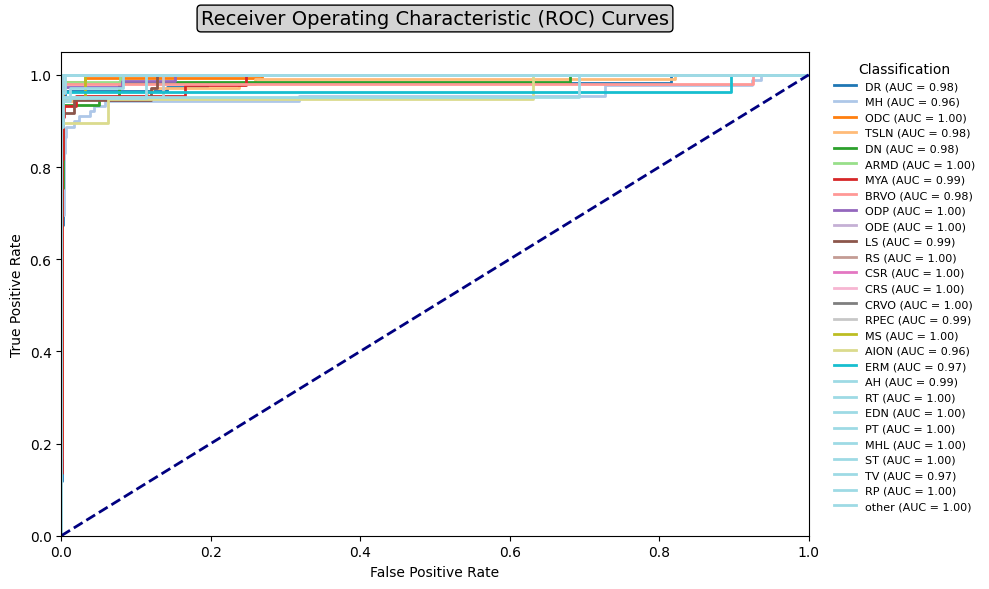

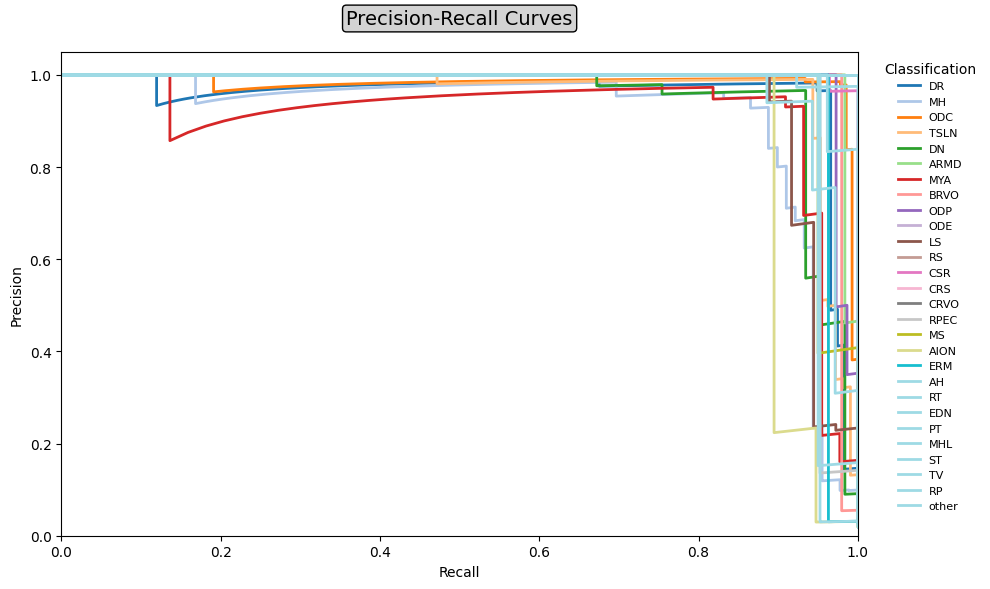

In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



n_classes = len(labels)

fig, ax = plt.subplots(figsize=(10, 6))


for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_test[:, i], final_predictions_array[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))


for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_test[:, i], final_predictions_array[:, i])
    plt.plot(recall, precision, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  
plt.tight_layout()
plt.show()


### Saving Trained Meta Logistic Regression Models

In this code  the trained meta logistic regression models are saved to disk using the `joblib` library. Saving the models allows them to be loaded and used for making predictions at a later time without needing to retrain them.

#### Saving Trained Meta Logistic Regression Models

- The code iterates over the list of trained logistic regression models, `meta_models`, which were previously trained for each label.

- For each model, a unique filename is generated based on the index `i`, and the filename includes the identifier "logistic_regression_model_" followed by the index. This helps distinguish and organize the saved models for each label.

- The `joblib.dump` function is used to save each logistic regression model to a separate joblib file with the generated filename. This serialized model file can be loaded later for inference.

- After running this code, you will have saved logistic regression models for each label as separate joblib files, making it convenient to load and use them for predictions without the need for retraining.

In [41]:
import joblib
for i, lr in enumerate(meta_models):
    filename = f'logistic_regression_model_{i}.joblib'
    joblib.dump(lr, filename)

### Zipping Logistic Regression Models

In this code  the trained logistic regression models are zipped into a single compressed archive. This can help with convenient storage, transfer, and sharing of the models.

#### Zipping Logistic Regression Models

- The code specifies a `zip_filename`, which is the path to the ZIP file that will contain the logistic regression models.

- An `output_directory` is defined as the directory where the logistic regression models are stored.

- Using the `zipfile.ZipFile` context manager, a new ZIP file with the specified name is created for writing (`'w'` mode).

- The code traverses through the contents of the `output_directory` using the `os.walk` function, which iterates over directories and files within it.

- For each file found within the `output_directory`, the code checks if the filename is not the same as the ZIP file that is being created to prevent including the ZIP file within itself.

- If the filename is not the ZIP file, the code creates the complete `file_path` by joining the `foldername` and the `filename`.

- The `zipf.write` function is used to add the `file_path` to the ZIP file with the base filename preserved.

- After iterating through all the files, the ZIP file is closed.

- A message is printed to indicate that the files have been zipped to the specified `zip_filename`.

This code allows you to create a ZIP archive containing the logistic regression models, making it easier to share or archive these models for future use.


In [42]:
import zipfile
import os

zip_filename = '/kaggle/working/Logistic Regression Models.zip'


output_directory = '/kaggle/working/'


with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk(output_directory):
        for filename in filenames:

            if filename != os.path.basename(zip_filename):
                file_path = os.path.join(foldername, filename)
                zipf.write(file_path, os.path.basename(file_path))

print(f"Files zipped to {zip_filename}")

Files zipped to /kaggle/working/Logistic Regression Models.zip
